In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import scipy.io.wavfile
import scipy
from scipy import signal
import math
import pandas as pd
from datetime import datetime
import timeit

In [145]:
# Helper function to generating a Waveforms
## FFT
def generateComplexWave(amp,freq,offset = 0,dur = 1,frate = 10000):
    ## To account for phase offset, think of it as:
    #--> Amp*exp(j * offset) ·exp(j*2*pi*f*t) = Amp*exp(i*2*pi*f*t+offset)
    amps = amp * np.exp(1j * offset)
    dt = 1/frate
    ts = np.arange(0, dur+dt, dt)
    # Matrix multiplication to reduce computation time
    ts_mat   = np.outer(ts, freq)
    wave_mat = np.exp(1j * 2 * np.pi * ts_mat ) 
    wave     = np.dot(wave_mat,amps)
    return wave,ts

def Complexsynthesizer(amps, freqs, ts):
    args = np.outer(ts, freqs)
    M = np.exp(1j * np.pi * 2 * args)
    ys = np.dot(M, amps)
    return ys

def linear_analyzer(wave,ts,freq):
    N       = len(wave)
    ts_mat  = np.outer(ts,freq)
    wave_mat = np.exp(1j * np.pi * 2 * ts_mat)
    amps = np.linalg.solve(wave_mat, wave)
    return amps  

def compressWave(fftspec,thresh = 10):
    count = 0
    for i in range(len(fftspec)):
        if abs(fftspec[i]) < thresh:
            fftspec[i] = 0
            count += 1
    return fftspec,100*count/len(fftspec)          

def dft_cwave(cwave):
    N = len(cwave)
    wave_mat = synthesis_matrix(N)
    amps = wave_mat.conj().transpose().dot(cwave)
    return amps

def idft_cwave(cwave):
    N = len(cwave)
    wave_mat = synthesis_matrix(N)
    amps = wave_mat.dot(cwave) / N
    return amps

def synthesis_matrix(N):
    ts = np.arange(N) / N
    fs = np.arange(N)
    ts_mat = np.outer(ts,fs)
    wave_mat = np.exp(1j * np.pi * 2 * ts_mat)
    return wave_mat

def genSawToothWave(amp = 1,freq = 1,off = 0,dur = 1,frate = 10000):
    if off < 0:
        print("ERROR: Offset must be greater than 0")
        return
    # Generate SawTooth waveform
    nframes   = int((frate/freq)+1)
    tempwav1  = np.linspace(-amp,amp,nframes)
    tempwav   = tempwav1[:nframes-1]
    # Shift to offset
    startidx = 0
    startidx += int(len(tempwav)*off)
    wavend   = tempwav[:startidx]
    wavstart = tempwav[startidx:]
    wavcycle = np.append(wavstart,wavend)
    # Extend by duration and eliminate consecutive dups
    nwavs,wavfrac = divmod(dur,1/freq)
    wavextended1  = np.tile(wavcycle,int(nwavs))
    wavextended2  = wavcycle[:int(wavfrac*len(wavcycle))]
    wavout = np.append(wavextended1,wavextended2)
    ts2 = np.arange(0,dur,1/frate)
    # Generate Timestamps
    ts         = np.linspace(0,dur,len(wavout))
    #print(2*nframes,len(ts),len(ts2))
    return ts,wavout

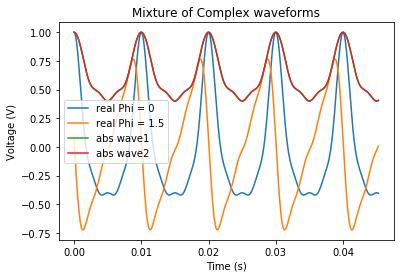

In [116]:
# Generating a complex wave
amps  = np.array([0.6,0.25,0.1,0.05]) 
freqs = [100,200,300,400]
wave,ts = generateComplexWave(amp = amps,freq = freqs,frate = 11024)
# To account for phase offset, think of it as:
## Amp*exp(i * offset) ·exp(i*2*pi*f*t) = Amp*exp(i2pft+f0
phi = 1.5
wave2,ts2 = generateComplexWave(amp = amps,offset = phi,freq = freqs,frate = 11024)
plt.plot(ts[:500],wave.real[:500])
plt.plot(ts2[:500],wave2.real[:500])
plt.plot(ts[:500],np.absolute(wave[:500]))
plt.plot(ts2[:500],np.absolute(wave2[:500]))

plt.title('Mixture of Complex waveforms')
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend(['real Phi = 0','real Phi = 1.5','abs wave1','abs wave2'])

plt.show()

In [34]:
# Analysis:
# given a sequence of samples and knowing the frequencies that make up the signal
# compute the complex amplitudes of the components
N    = 4
amps = np.array([0.6, 0.25, 0.1, 0.05])
freqs = np.arange(N)
ts    = np.arange(N) / N
cwave = Complexsynthesizer(amps, freqs, ts)
amplitudes = linear_analyzer(cwave[:n],freqs,ts[:n])
print(amplitudes.real)

[ 0.6   0.25  0.1   0.05]


In [38]:
# Analyzing DFT and iDFT functions
N    = 4
amps = np.array([0.6, 0.25, 0.1, 0.05])
freqs = np.arange(N)
ts    = np.arange(N) / N
cwave1  = Complexsynthesizer(amps, freqs, ts)
# FFT
amp  = dft_cwave(cwave1)
amp2 = np.fft.fft(cwave1)
amp3 = scipy.fftpack.fft(cwave1)
# iFFt
cwave2_1 = idft_cwave(amp)
cwave2_2 = np.fft.ifft(amp2)
cwave2_3 = scipy.fftpack.ifft(amp3)
# Taking the ifft of fft[@ N,freqs,ts] will return the original amplitude of the freqs
print(cwave2_1)
print(cwave2_2)
print(cwave2_3)

[ 1.0 -1.01234384e-16j  0.5 +2.00000000e-01j  0.4 +8.00040872e-17j
  0.5 -2.00000000e-01j]
[ 1.0 -1.54074396e-33j  0.5 +2.00000000e-01j  0.4 +2.44929360e-17j
  0.5 -2.00000000e-01j]
[ 1.0 -1.54074396e-33j  0.5 +2.00000000e-01j  0.4 +2.44929360e-17j
  0.5 -2.00000000e-01j]


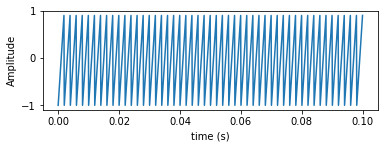

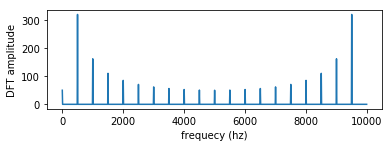

Notice that the frequency power spectrum folds at Nyquest frequency (Frate/2):
	This is do to Aliasing


In [94]:
## Applying DFT/iDFT on abstract signal
ts,stwave = genSawToothWave(freq = 500,dur = 0.1,frate = 10000)
sd.play(stwave,10000)
power     = dft_cwave(stwave)
N = len(power)
fqs       = np.arange(N) * 10000 / N
plt.subplot(211)
plt.plot(ts,stwave)
plt.xlabel('time (s)')
plt.ylabel('Amplitude')
plt.show()
plt.subplot(212)
plt.plot(fqs,np.absolute(power))
plt.xlabel('frequecy (hz)')
plt.ylabel('DFT amplitude')
plt.show()
print("Notice that the frequency power spectrum folds at Nyquest frequency (Frate/2):")
print("\tThis is do to Aliasing")

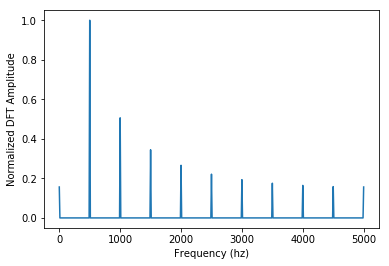

Strongest frequencies occur at:
 [    0.   500.  1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.
  5000.]
with a complex waveforms of:
 [ -1.00000000e+03 -1.38158882e-10j  -1.13483390e-10 +5.73349001e-11j
  -1.00000000e+03 -4.72618001e-11j   5.01358445e-11 +4.48363030e-11j
  -1.00000000e+03 +7.79428397e-11j  -5.19873708e-11 +4.44509820e-11j
  -1.00000000e+03 -2.60492667e-10j  -1.27864027e-10 +9.97489822e-12j
  -1.00000000e+03 -1.86977786e-10j   5.83185229e-11 -1.46116159e-11j
  -1.00000000e+03 +2.95963243e-11j]


In [128]:
# Analyzing amplitudes of strongest frequencies
mpower = np.amax(np.absolute(power))
npower = np.absolute(power)/mpower
pidx   = npower > 0.15
# correct for fold due to aliasing
fnpower = npower[:N//2+1]
ffqs   = fqs[:N//2+1]
fpidx   = fnpower > 0.15
plt.plot(ffqs,fnpower)
plt.ylabel('Normalized DFT Amplitude')
plt.xlabel('Frequency (hz)')
plt.show()
# finding the complex amplitudes of the strongest frequencies in the waveform
print("Strongest frequencies occur at:\n",ffqs[fpidx])
amps     = dft_cwave(power)[:N//2+1]
print("with a complex waveforms of:\n",amps[fpidx])

By storing only the strongest waveform information, I can resynthesize the original wave


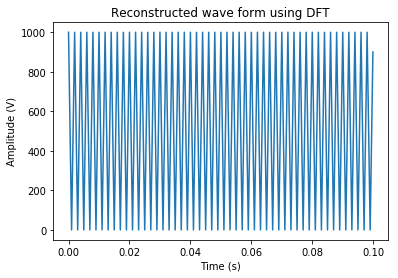

In this example, we excluded 98.0 % of the waveform information to reconstruct the wave


In [158]:
# Reconstructing waveform from minimal info
frate = 10000
power            = dft_cwave(stwave)
compression,perf = compressWave(power)
reconstruct      = dft_cwave(compression)
ts = np.arange(0,len(reconstruct)) * 1/frate
print("By storing only the strongest waveform information, I can resynthesize the original wave")
plt.plot(ts,np.absolute(reconstruct))
plt.title('Reconstructed wave form using DFT')
plt.ylabel('Amplitude (V)')
plt.xlabel('Time (s)')
plt.show()
print("In this example, we excluded",perf, "% of the waveform information to reconstruct the wave")

#res = np.fft.rfft(stwave)
#result,perf = compressWave(res)
#rec = np.fft.irfft(result)
